<a href="https://colab.research.google.com/github/Elmir22/Data-science-ML-models-/blob/main/deep_computer_vision_with_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_sample_images
import tensorflow as tf
import matplotlib.pyplot as plt


(-0.5, 639.5, 426.5, -0.5)

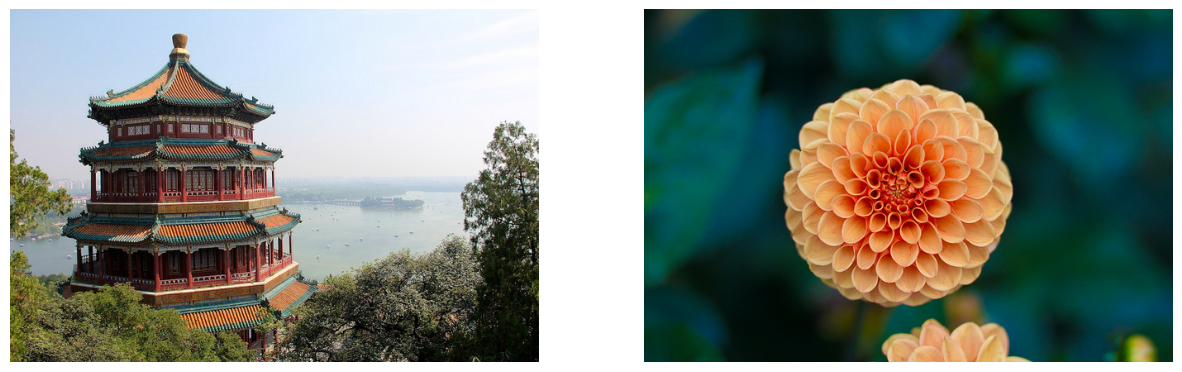

In [2]:
images = load_sample_images()['images']
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(images[0])
plt.axis('off')
plt.subplot(122)
plt.imshow(images[1])
plt.axis('off')

(-0.5, 119.5, 69.5, -0.5)

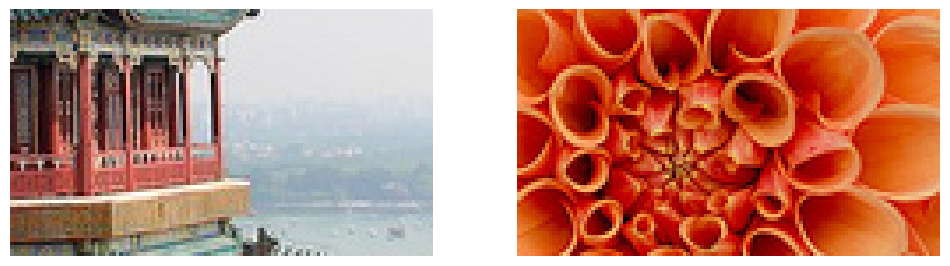

In [3]:
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1/255)(images)
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(images[0])
plt.axis('off')
plt.subplot(122)
plt.imshow(images[1])
plt.axis('off')

In [4]:
images.shape

TensorShape([2, 70, 120, 3])

In [5]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [6]:
fmaps.shape

TensorShape([2, 64, 114, 32])

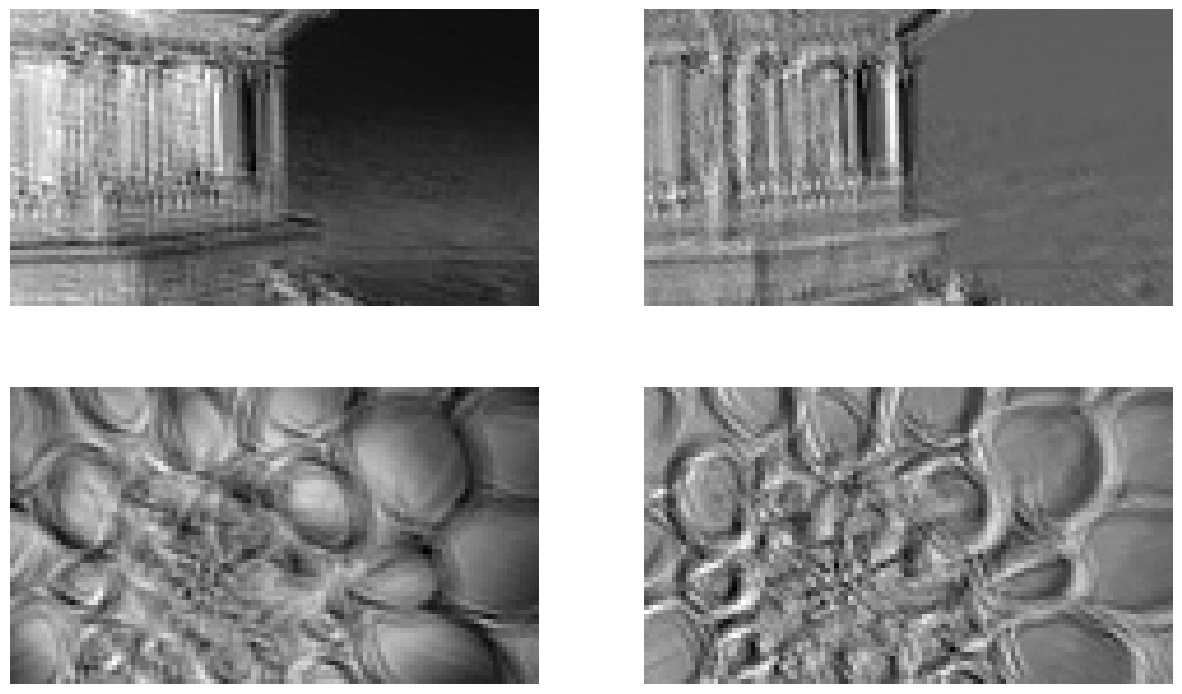

In [7]:
plt.figure(figsize=(15,9))
for image_idx in  (0,1):
    for fmap_idx in (0,1):
      plt.subplot(2,2 ,image_idx * 2 + fmap_idx + 1)
      plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap = 'gray')
      plt.axis("off")

plt.show()

In [8]:
conv_layer = tf.keras.layers.Conv2D(filters = 32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [9]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [10]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding = "same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [11]:
import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=10, strides=4, padding="same")

(array([18, 30]), array([8, 6]))

In [12]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [13]:
tf.random.set_seed(42)
filters = tf.random.normal([7,7,3,2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME")+ biases

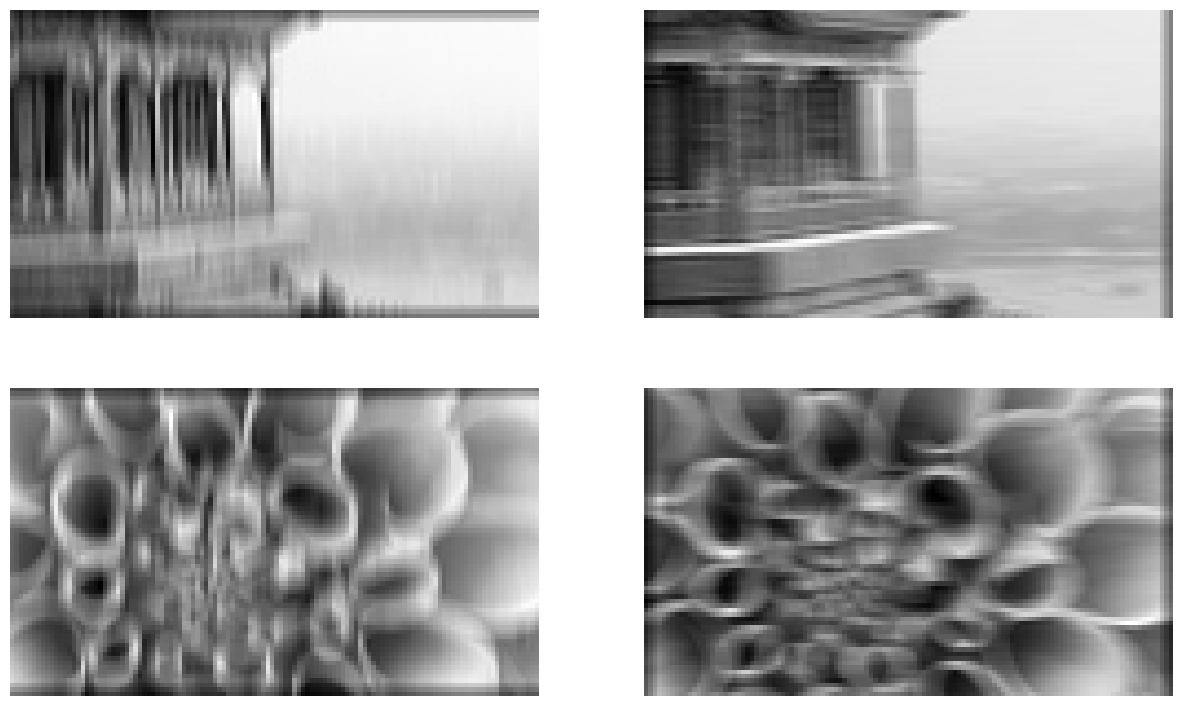

In [14]:
plt.figure(figsize=(15,9))
filters = np.zeros([7,7,3,2])
filters[:,3, :, 0] = 1
filters[3,:,:,1]=1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0,1):
  for fmap_idx in (0,1):
    plt.subplot(2,2, image_idx*2+fmap_idx + 1)
    plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
    plt.axis("off")

plt.show()

In [15]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)


In [16]:
output = max_pool(images)

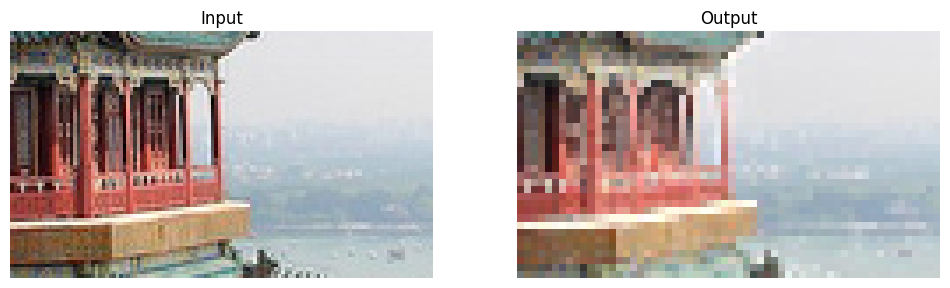

In [17]:
import matplotlib as mpl
fig = plt.figure(figsize=(12,8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios = [2,2])

ax1 = fig.add_subplot(gs[0,0])
ax1.set_title("Input")
ax1.imshow(images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0,1])
ax2.set_title("Output")
ax2.imshow(output[0])
ax2.axis('off')
plt.show()

#class DepthPool

In [18]:
class DepthPool(tf.keras.layers.Layer):
  def __init__(self, pool_size=2, **kwargs):
    super().__init__(**kwargs)
    self.pool_size = pool_size


  def call(self, inputs):
    shape = tf.shape(inputs)
    groups = shape[-1] // self.pool_size
    new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
    return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

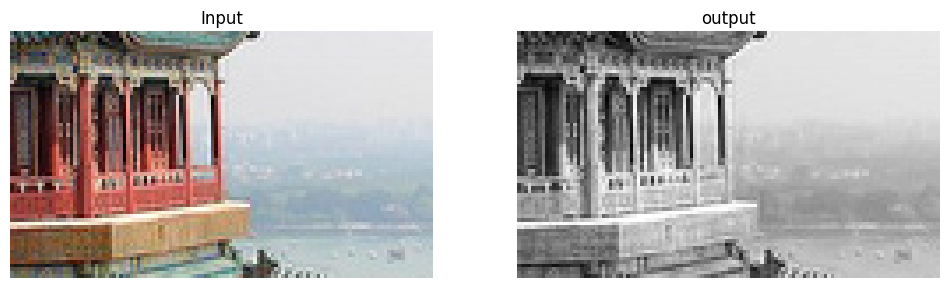

In [19]:
depth_output =  DepthPool(pool_size=3)(images)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('Input')
plt.imshow(images[0])
plt.axis('off')
plt.subplot(1,2,2)
plt.title('output')
plt.imshow(images[0, ... ,0], cmap="gray")
plt.axis("off")
plt.show()

#CNN architectures

#Tackling Fashion MNIST With a CNN

In [20]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [21]:
from functools import partial

tf.random.set_seed(42)
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3,padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28,28,1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

In [23]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 21s 11ms/step - loss: 0.2184 - accuracy: 0.9285 - val_loss: 0.2729 - val_accuracy: 0.9140
Epoch 2/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.2105 - accuracy: 0.9295 - val_loss: 0.2786 - val_accuracy: 0.9104
Epoch 3/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.1923 - accuracy: 0.9342 - val_loss: 0.2771 - val_accuracy: 0.9126
Epoch 4/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.1972 - accuracy: 0.9332 - val_loss: 0.2766 - val_accuracy: 0.9158
Epoch 5/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.1838 - accuracy: 0.9385 - val_loss: 0.2617 - val_accuracy: 0.9164
Epoch 6/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.1819 - accuracy: 0.9397 - val_loss: 0.2849 - val_accuracy: 0.9112
Epoch 7/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.1800 - accuracy: 0.9398 - val_loss: 0.3546 -

#Implementing a RESNET-34 CNN USING KERAS

In [35]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding='same', kernel_initializer='he_normal',
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
  def __init__(self, filters, strides=1, activation='relu', **kwargs):
    super().__init__(**kwargs)
    self.activation = tf.keras.activations.get(activation)
    self.main_layers = [
        DefaultConv2D(filters, strides=strides),
        tf.keras.layers.BatchNormalization(),
        self.activation,
        DefaultConv2D(filters),
        tf.keras.layers.BatchNormalization()
    ]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [
          DefaultConv2D(filters, kernel_size=1, strides=strides),
          tf.keras.layers.BatchNormalization()
      ]

  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [36]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

#using pretrained models from keras

In [38]:
model= tf.keras.applications.ResNet50(weights = "imagenet")

In [39]:
images=load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)

In [40]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [41]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 [==============================] - 3s 3s/step


(2, 1000)

In [42]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
  print(f"Image # {image_index}")
  for class_id, name, y_proba in top_K[image_index]:
    print(f" {class_id} - {name:12s}{y_proba:.2%}")

35363/35363 [==============================] - 0s 0us/step
Image # 0
 n03877845 - palace      54.69%
 n03781244 - monastery   24.71%
 n02825657 - bell_cote   18.55%
Image # 1
 n04522168 - vase        32.67%
 n11939491 - daisy       17.82%
 n03530642 - honeycomb   12.04%


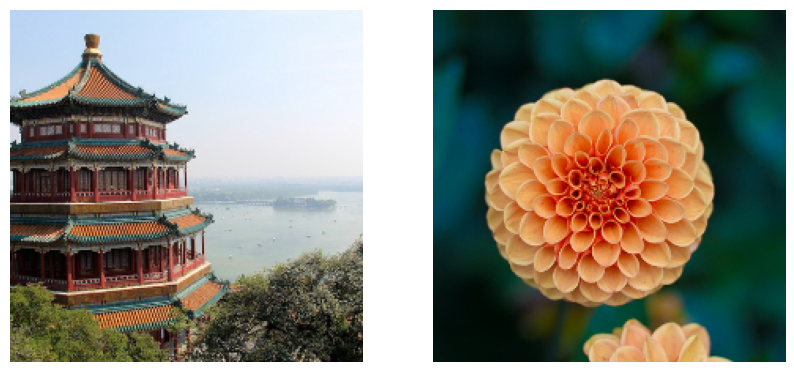

In [43]:
plt.figure(figsize=(10,6))
for idx in (0,1):
  plt.subplot(1,2, idx+1)
  plt.imshow(images_resized[idx]/255.)
  plt.axis('off')
plt.show()